# CS 4262: Predicting a Playlist for a Song

<br>by Keshvi Mahalingam, Zinnie Zhang</br>


In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
import time
import math
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Run "pip install spotipy" on your local computer
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
# Access Spotify Credentials
client_id = '6d02153904514353ac63fd23acba8d86'
client_secret = '06a9d4ba2e104061b268c6ba7a41c60f'
client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [3]:
# Get track ID for a specific user and playlist ID. (Playlist ID found in URL when clicking "share")
# n = number of songs 
def getTrackIDs(user, playlist_id, n = 100):
    ids = []
    playlist = sp.user_playlist(user, playlist_id)
    
    count = 0
    for item in playlist['tracks']['items']:
        track = item['track']
        ids.append(track['id'])
        count += 1
        if count == n: break
        
    return ids

# Get track features
def getTrackFeatures(id):
    meta = sp.track(id)
    features = sp.audio_features(id)

    # meta
    length = meta['duration_ms']
    popularity = meta['popularity']

    # features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    key = features[0]['key']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    mode = features[0]['mode']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    time_signature = features[0]['time_signature']
    valence = features[0]['valence']

    track = [length, popularity, acousticness, danceability, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature, valence]
    return track

# Loop track and create dataset
def trackCSV(ids, name):
    tracks = []
    for i in range(len(ids)):
        track = getTrackFeatures(ids[i])
        tracks.append(track)
    
    # create CSV
    df = pd.DataFrame(tracks, columns = ['length', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence'])
    df.to_csv(name + ".csv", sep = ',')
    print(name + 'CSV created\n')
    
    return df

In [4]:
happyIds = getTrackIDs('xinyizhang.x-ca', '37i9dQZF1DXdPec7aLTmlC')
happy_data = trackCSV(happyIds, 'happy')

sadIds = getTrackIDs('xinyizhang.x-ca', '6nxPNnmSE0d5WlplUsa5L3')
sad_data = trackCSV(sadIds, 'sad')

chillIds = getTrackIDs('xinyizhang.x-ca', '37i9dQZF1DX4WYpdgoIcn6')
chill_data = trackCSV(chillIds, 'chill')


happyCSV created

sadCSV created

chillCSV created



# Exploratory Data Analysis
General Statistics, Correlation Map, Visual Plot of Each Feature, PCA

Happy Songs General Statistics



<AxesSubplot:>

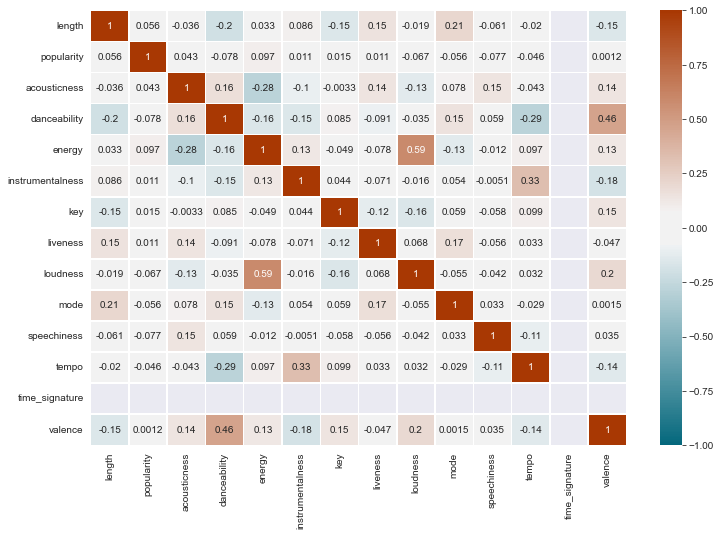

In [5]:
# [length, popularity, acousticness, danceability, energy, instrumentalness, 
# key, liveness, loudness, mode, speechiness, tempo, time_signature, valence]

# General Statistics
print('Happy Songs General Statistics\n')
happy_data.describe()

# Correlation Map
sns.set_style('darkgrid')
plt.figure(figsize = (12,8))
cmap = sns.diverging_palette(220, 20, l = 40, s = 99, sep = 20, center = 'light', as_cmap = True) 
sns.heatmap(happy_data.corr(), vmin = -1, vmax = 1, annot = True, cmap = cmap, lw = .5, linecolor = 'white')


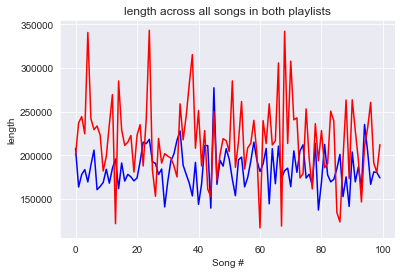

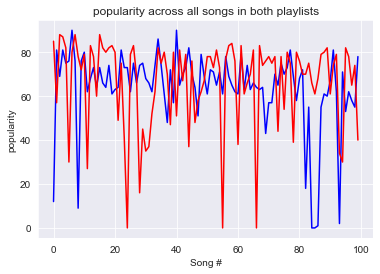

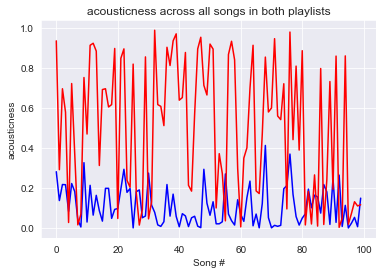

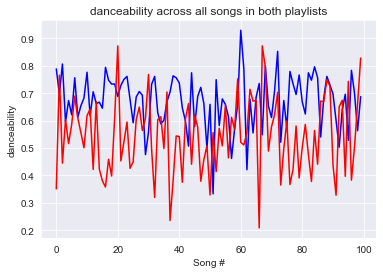

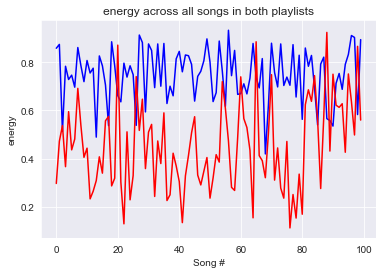

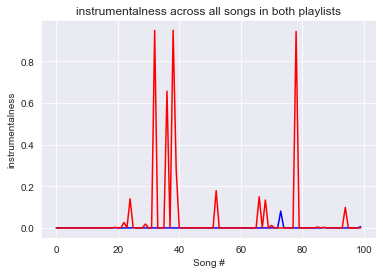

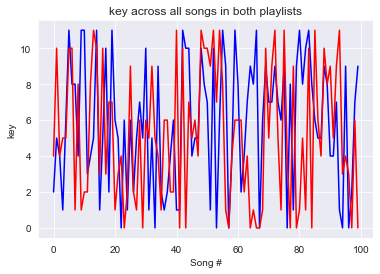

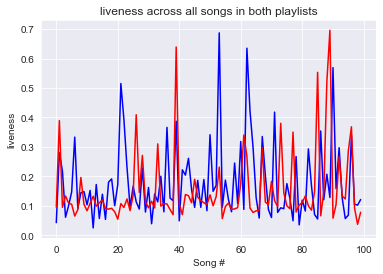

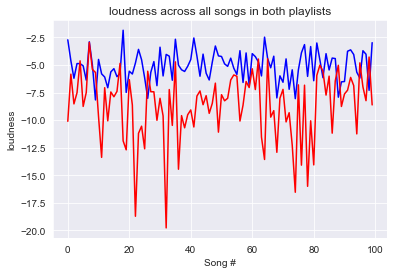

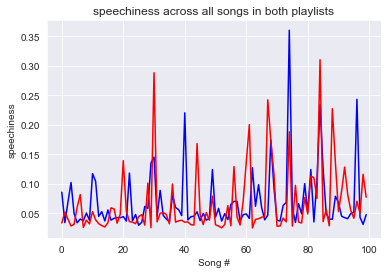

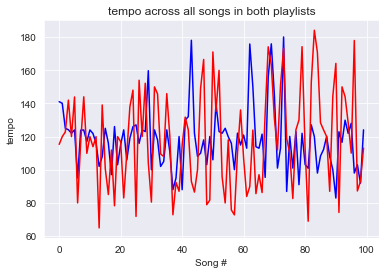

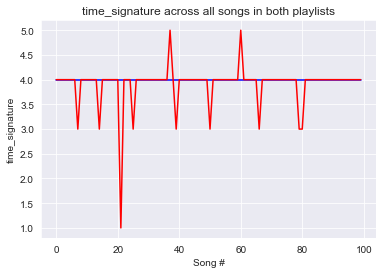

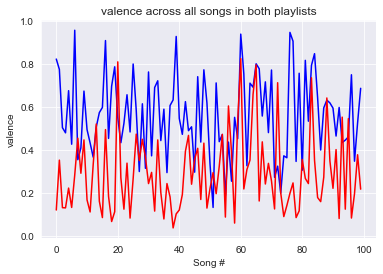

In [6]:
# Plot all features to visually see the greatest seperation
features = ['length', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature', 'valence']

for feature in features:
    plt.figure(feature)
    plt.plot(happy_data[feature], color='blue')
    plt.plot(sad_data[feature], color='red')
    plt.xlabel("Song #")
    plt.ylabel(feature)
    plt.title(feature + " across all songs in both playlists")



In [7]:
# Scale data
from sklearn.preprocessing import StandardScaler

# Happy data
scaler = StandardScaler()
scaler.fit(happy_data)
scaled_happy_data = scaler.transform(happy_data)

# Sad data
scaler = StandardScaler()
scaler.fit(sad_data)
scaled_sad_data = scaler.transform(sad_data)

# Combine data
df_scaled_happy = pd.DataFrame(scaled_happy_data, columns = ['length', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence'])
df_scaled_sad = pd.DataFrame(scaled_sad_data, columns = ['length', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence'])
combined = pd.concat([df_scaled_happy, df_scaled_sad])

Text(0, 0.5, 'Ratio of Variance Explained')

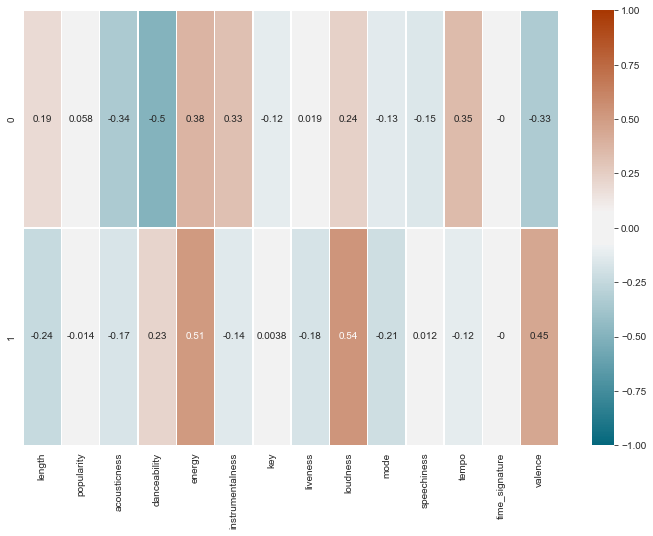

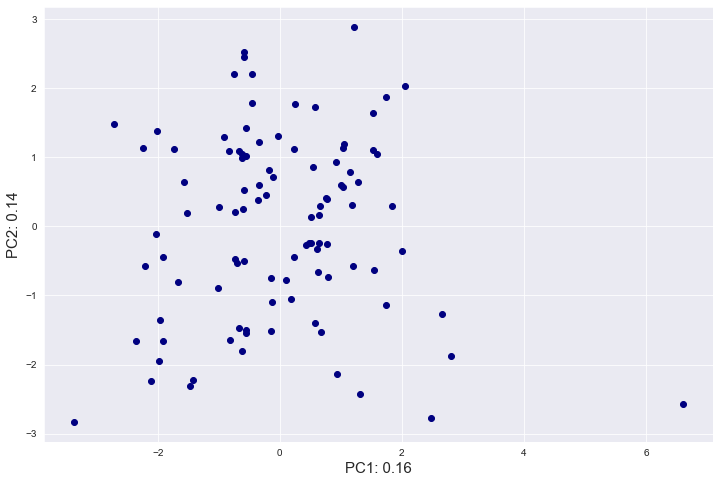

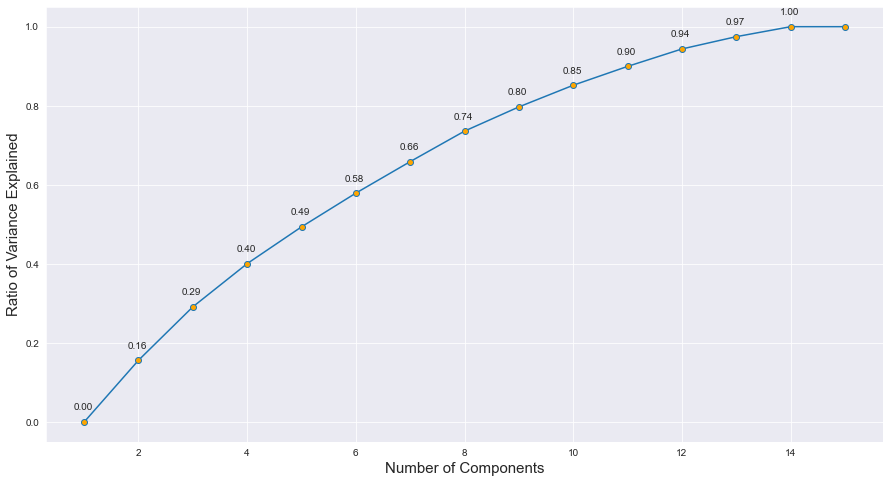

In [8]:
# PCA with 2 components

pca = PCA(n_components = 2)
pca.fit(scaled_happy_data)
data_pca = pca.transform(scaled_happy_data)

pca_corr = pd.DataFrame(pca.components_, columns = happy_data.columns)

plt.figure(figsize = (12,8))
sns.heatmap(pca_corr, cmap = cmap, vmin = -1, vmax = 1, annot = True, lw = .5, linecolor = 'white')

plt.figure(figsize = (12, 8))
plt.scatter(data_pca[:,0], data_pca[:,1], c = 'navy')
plt.xlabel('PC1: {:.2f}'.format(pca.explained_variance_ratio_[0]), size = 15)
plt.ylabel('PC2: {:.2f}'.format(pca.explained_variance_ratio_[1]), size = 15)

# PCA with 0-14 components
exp_var_ratio = []
for n in range(0,15):
    pca = PCA(n_components = n)
    pca.fit(scaled_happy_data)
    pca.transform(scaled_happy_data)
    exp_var_ratio.append(sum(pca.explained_variance_ratio_))

fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(111)
plt.plot(range(1,16), exp_var_ratio, marker = 'o', markerfacecolor = 'orange', markersize = 6)

for i,j in zip(range(1,15),exp_var_ratio):
    ax.annotate('{:.2f}'.format(j),xy=(i-.2,j+.03))
plt.xlabel('Number of Components', size = 15)
plt.ylabel('Ratio of Variance Explained', size = 15)

# Performance 
Functions to evaluate and display performance 

In [9]:
def printPerformance(prediction, correct):
    count_correct = 0
    m = len(prediction)
    
    for i in range(m):
        if prediction[i] == correct[i]: count_correct +=1
   
    performance = count_correct/m
    
    return performance

def plotPerformances(performances, modelName):
    plt.figure()
    plt.plot([2, 3, 4, 5], performances)
    title = '# Input Features vs ' + modelName + ' Performance'
    y_axis = modelName + ' Model Performance'
    plt.title(title)
    plt.xlabel('# of Input Features')
    plt.ylabel(y_axis)
    plt.show()

# K-Nearest Neighbors
Values are not scaled

In [10]:
# Happy = 0
# Sad = 1

from sklearn.model_selection import train_test_split
# 5 features: "acousticness", "energy", "loudness", "valence", "danceability"
# 2 features: "acousticness", "energy"
#reduced_happy = happy_data[["acousticness", "energy"]]
#reduced_sad = sad_data[["acousticness", "energy"]]
#reduced_combined = pd.concat([reduced_happy, reduced_sad])

y0 = [0]*100
y1 = [1]*100
y = y0 + y1

# Split into train, test
#X_train, X_test, y_train, y_test = train_test_split(reduced_combined, y, test_size=0.3, random_state=30, shuffle=True)

# Create datasets with 2-5 features
train_x = {}
train_y = {}
test_x = {}
test_y = {}
features = ["acousticness", "energy", "loudness", "valence", "danceability"]

for i in range(2,6):
    reduced_happy = happy_data[features[0:i]]
    reduced_sad = sad_data[features[0:i]]
    reduced_combined = pd.concat([reduced_happy, reduced_sad])
    X_train, X_test, y_train, y_test = train_test_split(reduced_combined, y, test_size=0.3, random_state=30, shuffle=True)
    train_x[i] = X_train
    train_y[i] = y_train
    test_x[i] = X_test
    test_y[i] = y_test
    
print(train_x[2])
    


    acousticness  energy
5        0.22200   0.747
8        0.00515   0.787
80       0.88500   0.168
94       0.11300   0.792
42       0.06030   0.831
..           ...     ...
40       0.63800   0.304
45       0.05860   0.639
73       0.54100   0.277
65       0.18500   0.886
37       0.05930   0.701

[140 rows x 2 columns]


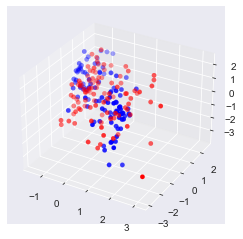

In [11]:
# Visualize the reduced data
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_scaled_happy["acousticness"], df_scaled_happy["energy"], df_scaled_happy["loudness"], linewidth=0.2, color = "red")
ax.scatter(df_scaled_sad["acousticness"], df_scaled_sad["energy"], df_scaled_sad["loudness"], linewidth=0.2, color = "blue")
plt.show()

In [12]:
# KNN Hyperparameter Tuning
#List Hyperparameters that we want to tune.
n_neighbors = list(range(1,30))
p=[1,2]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']

#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors, p=p, weights=weights, metric=metric)

#Create new KNN object
knn_2 = KNeighborsClassifier()

#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=5, verbose=True)

#Fit the model
best_knn_model = clf.fit(train_x[5], train_y[5])

#Print the values of best Hyperparameters
print("# input features:", 5)
print('Best p:', best_knn_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_knn_model.best_estimator_.get_params()['n_neighbors'])
print('Best weights:', best_knn_model.best_estimator_.get_params()['weights'])
print('Best metric:', best_knn_model.best_estimator_.get_params()['metric'])
print('')
print('Mean Accuracy: %.3f' % best_knn_model.best_score_)
print('')

Fitting 5 folds for each of 348 candidates, totalling 1740 fits
# input features: 5
Best p: 1
Best n_neighbors: 7
Best weights: distance
Best metric: manhattan

Mean Accuracy: 0.843



KNN Performance (k = 7):
2 features: 0.85
3 features: 0.8833333333333333
4 features: 0.9
5 features: 0.9


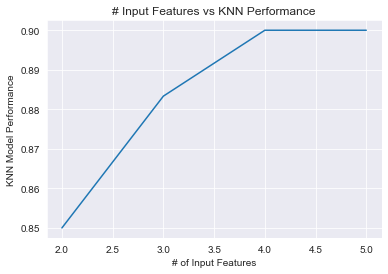

In [13]:
knn_performances = []

k = best_knn_model.best_estimator_.get_params()['n_neighbors']
print("KNN Performance (k = {}):".format(k))

# Train model
for i in range(2,6):
    knn = KNeighborsClassifier(**best_knn_model.best_params_)
    knn.fit(train_x[i], train_y[i])

    # Make predictions
    prediction = knn.predict(test_x[i])
    print(i, "features:", printPerformance(prediction, test_y[i]))
    knn_performances.append(printPerformance(prediction, test_y[i]))

plotPerformances(knn_performances, 'KNN')

# LDA & QDA

In [14]:
# LDA Hyperparameter Tuning
# define model
lda_estimator1 = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=50, n_repeats=3, random_state=1)
# define parameter grid
grid = dict()
grid['solver'] = ['svd']
grid['store_covariance'] = [True, False]         # only used for svd solver
grid['tol'] = [0.0, 0.0001, 0.001, 0.01, 0.1]    # only used for svd solver
# define grid search
search = GridSearchCV(lda_estimator1, grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=True)
# perform the search
best_lda_model1 = search.fit(train_x[i], train_y[i])
# summarize best hyperparameter values
print("# input features:", i)
print('Best solver:', best_lda_model1.best_estimator_.get_params()['solver'])
print('Best store_covariance:', best_lda_model1.best_estimator_.get_params()['store_covariance'])
print('Best tol:', best_lda_model1.best_estimator_.get_params()['tol'])
print('Mean Accuracy: %.3f' % best_lda_model1.best_score_)
print('')


# define model
lda_estimator2 = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=50, n_repeats=3, random_state=1)
# define parameter grid
grid = dict()
grid['solver'] = ['lsqr', 'eigen']
grid['shrinkage'] = ['auto', np.arange(0, 1, 0.01)]    # only used for lsqr & eigen solvers
# define grid search
search = GridSearchCV(lda_estimator2, grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=True)
# perform the search
best_lda_model2 = search.fit(train_x[i], train_y[i])  
# summarize best hyperparameter values
print("# input features:", i)
print('Best solver:', best_lda_model2.best_estimator_.get_params()['solver'])
print('Best shrinkage:', best_lda_model2.best_estimator_.get_params()['shrinkage'])
print('Mean Accuracy: %.3f' % best_lda_model2.best_score_)


# choose b/w SVD and non-SVD solver
if (best_lda_model1.best_score_ >= best_lda_model2.best_score_):
    best_lda_model = best_lda_model1
else:
    best_lda_model = best_lda_model2

Fitting 150 folds for each of 10 candidates, totalling 1500 fits
# input features: 5
Best solver: svd
Best store_covariance: True
Best tol: 0.0
Mean Accuracy: 0.878

Fitting 150 folds for each of 4 candidates, totalling 600 fits
# input features: 5
Best solver: lsqr
Best shrinkage: auto
Mean Accuracy: 0.879


In [15]:
# QDA Hyperparameter Tuning
qda_estimator = QuadraticDiscriminantAnalysis()
qda_params = {
    'reg_param': (0, 0.00001, 0.0001, 0.001, 0.01, 0.1), 
    'store_covariance': (True, False),
    'tol': (0.0001, 0.001, 0.01, 0.1)
}

# with GridSearch
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search_qda = GridSearchCV(
    estimator=qda_estimator,
    param_grid=qda_params,
    n_jobs = -1,
    cv = cv,
    verbose = True
)

# fit model
best_qda_model=grid_search_qda.fit(train_x[5], train_y[5])

# summarize best hyperparameter values
print('Best reg_param:', best_qda_model.best_estimator_.get_params()['reg_param'])
print('Best store_covariance:', best_qda_model.best_estimator_.get_params()['store_covariance'])
print('Best tol:', best_qda_model.best_estimator_.get_params()['tol'])
print('')
print('Mean Accuracy: %.3f' % best_qda_model.best_score_)

Fitting 30 folds for each of 48 candidates, totalling 1440 fits
Best reg_param: 0.001
Best store_covariance: True
Best tol: 0.0001

Mean Accuracy: 0.845


LDA Performance:
2 features: 0.8
3 features: 0.8
4 features: 0.8833333333333333
5 features: 0.9

QDA Performance:
2 features: 0.8333333333333334
3 features: 0.8833333333333333
4 features: 0.9166666666666666
5 features: 0.9


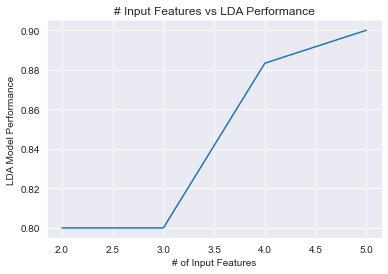

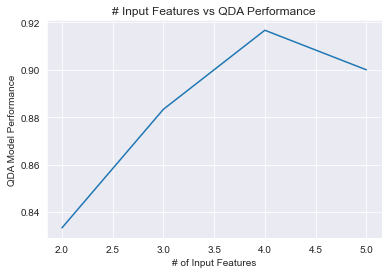

In [16]:
lda_performances = []
qda_performances = []

print("LDA Performance:")
# Train model
for i in range(2,6):
    lda_train_x = np.array(train_x[i])
    lda_train_y = np.array(train_y[i])
    lda_test_x = np.array(test_x[i])
    
    clf = LinearDiscriminantAnalysis(**best_lda_model.best_params_)
    clf.fit(lda_train_x, lda_train_y)
    lda_prediction = clf.predict(lda_test_x)
    print(i, "features:", printPerformance(lda_prediction, test_y[i]))
    lda_performances.append(printPerformance(lda_prediction, test_y[i]))

print("\nQDA Performance:")
# Train model
for i in range(2,6):
    qda_train_x = np.array(train_x[i])
    qda_train_y = np.array(train_y[i])
    qda_test_x = np.array(test_x[i])
    
    clf = QuadraticDiscriminantAnalysis(**best_qda_model.best_params_)
    clf.fit(qda_train_x, qda_train_y)
    qda_prediction = clf.predict(qda_test_x)
    print(i, "features:", printPerformance(qda_prediction, test_y[i]))
    qda_performances.append(printPerformance(qda_prediction, test_y[i]))

# plot LDA performances
plotPerformances(lda_performances, 'LDA')
#plot QDA performances
plotPerformances(qda_performances, 'QDA')

# Logistic Regression

In [17]:
# Logistic Regression Hyperparameter Tuning
lr_estimator = LogisticRegression()

lr_params = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000, 2500, 5000],
     'random_state' : [0]
    }
]

clf2 = GridSearchCV(lr_estimator, param_grid = lr_params, cv = 5, verbose=True, n_jobs=-1)
best_lr_model1 = clf2.fit(train_x[5], train_y[5])
print('Best penalty:', best_lr_model1.best_estimator_.get_params()['penalty'])
print('Best C:', best_lr_model1.best_estimator_.get_params()['C'])
print('Best solver:', best_lr_model1.best_estimator_.get_params()['solver'])
print('Best max_iter:', best_lr_model1.best_estimator_.get_params()['max_iter'])
print('')
print('Mean Accuracy: %.3f' % best_lr_model1.best_score_)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits
Best penalty: none
Best C: 0.0001
Best solver: lbfgs
Best max_iter: 100

Mean Accuracy: 0.879


Logistic Regression Performance:
2 features: 0.8
3 features: 0.8166666666666667
4 features: 0.8833333333333333
5 features: 0.9166666666666666


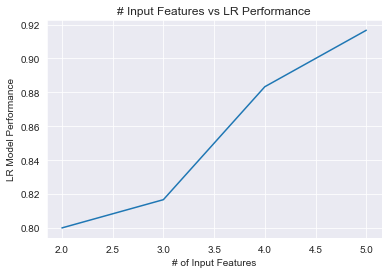

In [18]:
lr_performances = []

print("Logistic Regression Performance:")
# Train model
for i in range(2,6):
    lr = LogisticRegression(**best_lr_model1.best_params_).fit(train_x[i], train_y[i])

    # Make predictions
    prediction = lr.predict(test_x[i])
    print(i, "features:", printPerformance(prediction, test_y[i]))
    lr_performances.append(printPerformance(prediction, test_y[i]))
    
plotPerformances(lr_performances, 'LR')

# Decision Tree

In [29]:
# Decision Tree Hyperparameter Tuning
dt_estimator = DecisionTreeClassifier()

dt_params = [    
    {'criterion' : ['gini', 'entropy'],
     'min_samples_leaf' : [1, 3, 5, 10],
     'min_impurity_decrease' : [0.0, 0.0001, 0.001, 0.005, 0.01, 0.05],
     'splitter' : ['best', 'random'],
     'max_depth' : [1, 3, 5, 10],
     'ccp_alpha' : [0.0, 0.001, 0.005, 0.01, 0.05, 0.1],
     'random_state' : [0]
    }
]

clf3 = GridSearchCV(dt_estimator, param_grid = dt_params, cv=5, verbose=True, n_jobs=-1)

# perform search
best_dt_model = clf3.fit(train_x[5], train_y[5])

# summarize best hyperparameter values
print('Best criterion:', best_dt_model.best_estimator_.get_params()['criterion'])
print('Best min_samples_leaf:', best_dt_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_impurity_decrease:', best_dt_model.best_estimator_.get_params()['min_impurity_decrease'])
print('Best splitter:', best_dt_model.best_estimator_.get_params()['splitter'])
print('Best max_depth:', best_dt_model.best_estimator_.get_params()['max_depth'])
print('Best ccp_alpha:', best_dt_model.best_estimator_.get_params()['ccp_alpha'])
print('')
print('Mean Accuracy: %.3f' % best_dt_model.best_score_)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
Best criterion: gini
Best min_samples_leaf: 3
Best min_impurity_decrease: 0.0
Best splitter: random
Best max_depth: 5
Best ccp_alpha: 0.0

Mean Accuracy: 0.879


Decision Tree Classifier Performance:
2 features: 0.7666666666666667
3 features: 0.85
4 features: 0.8666666666666667
5 features: 0.8666666666666667


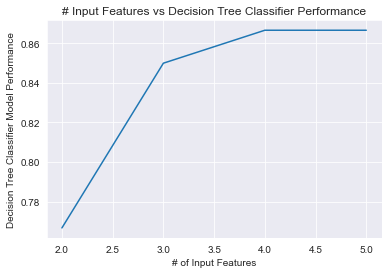

In [30]:
dt_performances = []
print("Decision Tree Classifier Performance:")
# Train model
for i in range(2,6):
    dt = DecisionTreeClassifier(**best_dt_model.best_params_).fit(train_x[i], train_y[i])

    # Make predictions
    prediction = dt.predict(test_x[i])
    print(i, "features:", printPerformance(prediction, test_y[i]))
    dt_performances.append(printPerformance(prediction, test_y[i]))

plotPerformances(dt_performances, 'Decision Tree Classifier')